<a href="https://colab.research.google.com/github/gsarm78/MetaSegmentation/blob/main/Clustering_SatelliteImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RUN with GPU enabled

Revision 2 - gs

In [1]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Data are renamed with a numbered filename
!unzip /content/drive/My\ Drive/cs330Data/data2.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/__MACOSX/train/._2015.png  
  inflating: /content/data/train/2940.png  
  inflating: /content/data/__MACOSX/train/._2940.png  
  inflating: /content/data/train/3486.png  
  inflating: /content/data/__MACOSX/train/._3486.png  
  inflating: /content/data/train/2798.png  
  inflating: /content/data/__MACOSX/train/._2798.png  
  inflating: /content/data/train/1291.png  
  inflating: /content/data/__MACOSX/train/._1291.png  
  inflating: /content/data/train/705.png  
  inflating: /content/data/__MACOSX/train/._705.png  
  inflating: /content/data/train/711.png  
  inflating: /content/data/__MACOSX/train/._711.png  
  inflating: /content/data/train/1285.png  
  inflating: /content/data/__MACOSX/train/._1285.png  
  inflating: /content/data/train/2954.png  
  inflating: /content/data/__MACOSX/train/._2954.png  
  inflating: /content/data/train/3492.png  
  inflating: /content/data/__MACOSX/train/._3492.png  
  infla

In [4]:
rm -r /content/data/__MACOSX

In [5]:
path = r"/content/data/train"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
images = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the images list
            images.append(file.name)

In [6]:
# load the image as a 224x224 array
img = load_img(images[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)
#(224, 224, 3)

(224, 224, 3)


In [7]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


In [8]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features
   
data = {}
p = r"/content/features.pkl"

# lop through each image in the dataset
for satimage in images:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(satimage,model)
        data[satimage] = feat
    # if something fails, save the extracted features as a pickle file
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

553467904/553467096 [==============================] - 21s 0us/step


In [9]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape

(3903, 1, 4096)

In [30]:
feat.shape[-1]

4096

In [31]:
# reshape so that there are xyz samples of 4096 vectors
feat = feat.reshape(-1,feat.shape[-1])
feat.shape

(3903, 4096)

In [32]:
# get the unique labels 
#df = pd.read_csv('masks.csv')
#label = df['label'].tolist()
#unique_labels = list(set(label))

In [33]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [34]:
# cluster feature vectors

k_value = 6

#kmeans = KMeans(n_clusters=k_value,n_jobs=-1, random_state=22) ###WORKS
kmeans = KMeans(n_clusters=k_value, init='k-means++', n_jobs=-1, random_state=22)
kmeans.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=22, tol=0.0001, verbose=0)

In [35]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [36]:
# function to view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

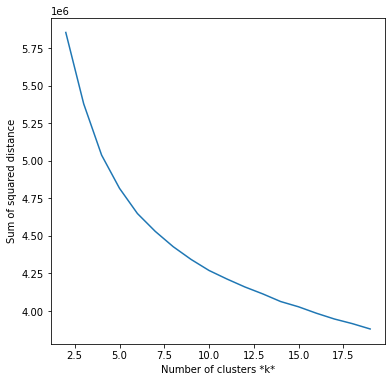

In [37]:
# Elbow - see which value for k might be the best 
sse = []
list_k = list(range(2, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Clipping cluster size from 299 to 30


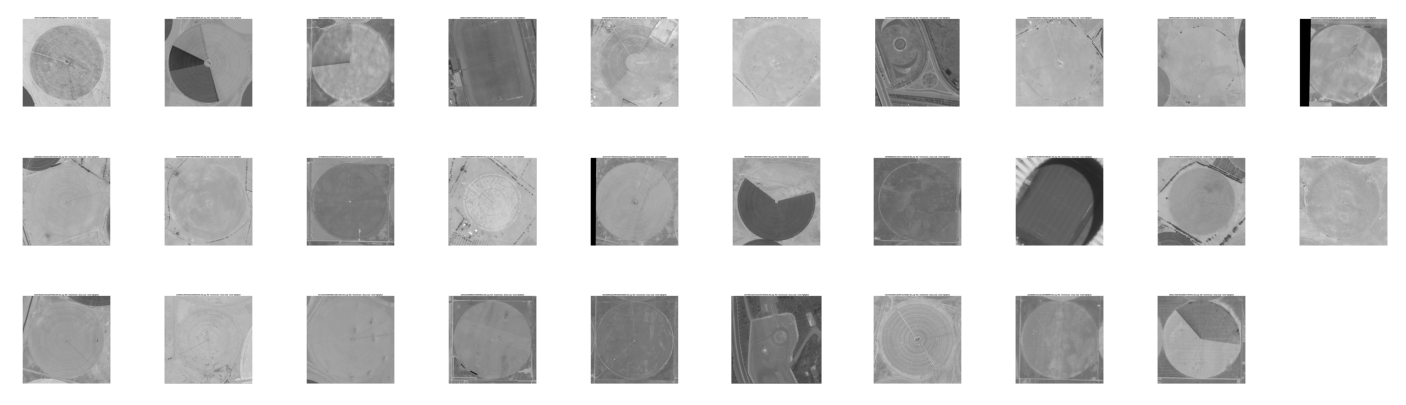

In [38]:
#Cluster 1 
view_cluster(0)

In [19]:
groups[0]

['637.png',
 '738.png',
 '2363.png',
 '1949.png',
 '2105.png',
 '3307.png',
 '202.png',
 '1571.png',
 '576.png',
 '822.png',
 '2496.png',
 '1189.png',
 '3480.png',
 '3350.png',
 '1475.png',
 '3172.png',
 '569.png',
 '3026.png',
 '1584.png',
 '1750.png',
 '1141.png',
 '1920.png',
 '1262.png',
 '1472.png',
 '1199_.png',
 '3144.png',
 '3742.png',
 '771.png',
 '3469.png',
 '1671.png',
 '3379.png',
 '2608.png',
 '3099.png',
 '2574.png',
 '2349.png',
 '1883.png',
 '1894.png',
 '2143.png',
 '2538.png',
 '816.png',
 '1771.png',
 '1462.png',
 '1614.png',
 '1586.png',
 '260.png',
 '1201.png',
 '2639.png',
 '530.png',
 '2826.png',
 '5.png',
 '1519.png',
 '910.png',
 '3453.png',
 '56.png',
 '2112.png',
 '3206.png',
 '2247.png',
 '151.png',
 '310.png',
 '3058.png',
 '1890.png',
 '1404.png',
 '2634.png',
 '2957.png',
 '2813.png',
 '547.png',
 '1183.png',
 '1005.png',
 '1876.png',
 '1068.png',
 '2980.png',
 '2296.png',
 '1232.png',
 '3312.png',
 '1386.png',
 '2527.png',
 '3483.png',
 '3852.png',
 '36